# Table of Contents
 <p><div class="lev1 toc-item"><a href="#OSMI-Mental-Health-In-Tech-:-Time-Dependent-Model-Selection" data-toc-modified-id="OSMI-Mental-Health-In-Tech-:-Time-Dependent-Model-Selection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>OSMI Mental Health In Tech : Time-Dependent Model Selection</a></div><div class="lev1 toc-item"><a href="#Initial-Modeling" data-toc-modified-id="Initial-Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initial Modeling</a></div><div class="lev2 toc-item"><a href="#Old-Model" data-toc-modified-id="Old-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Old Model</a></div><div class="lev2 toc-item"><a href="#Old-Model-with-Time-Effects" data-toc-modified-id="Old-Model-with-Time-Effects-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Old Model with Time Effects</a></div><div class="lev2 toc-item"><a href="#Decision-Tree-with-Time-Effects" data-toc-modified-id="Decision-Tree-with-Time-Effects-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Decision Tree with Time Effects</a></div><div class="lev1 toc-item"><a href="#Model-Selection" data-toc-modified-id="Model-Selection-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Selection</a></div>

# OSMI Mental Health In Tech : Time-Dependent Model Selection

_By [Michael Rosenberg](mailto:mmrosenb@andrew.cmu.edu)._

_**Description**: Contains my model selection for our model with time-varying effects._

_Last Updated: 5/1/2017 3:59 PM._

In [61]:
#imports

library(readr)
library(dplyr)
library(ggplot2)
library(tree)

#constants

sigLev = 3

In [62]:
timeDepFrame = read_csv(
                "../../data/processed/timeDataset_withCountryDummies.csv")

Parsed with column specification:
cols(
  companySize = col_character(),
  diagnosedWithMHD = col_integer(),
  gender = col_character(),
  age = col_integer(),
  year = col_integer(),
  workCountry = col_character(),
  isUSA = col_integer(),
  isUK = col_integer(),
  isCA = col_integer()
)


# Initial Modeling

Let's start by extracting our old model and studying its effectiveness on our current sample.

## Old Model

In [63]:
oldFormFilename = "../../models/finalLogisticRegressionFormula.txt"
oldModForm = readChar(oldFormFilename,
                      nchars = file.info(oldFormFilename)$size - 1)
print(oldModForm)

[1] "diagnosedWithMHD ~ age+factor(gender)+factor(roleType)+factor(isUSA)+age:factor(gender)"


We see one factor that we must unfortunately not consider is ```roleType```, since this feature was not available in the $2014$ data. Thus, we will build this model as a logistic regression without roleType.

In [64]:
oldMod.logr = glm(diagnosedWithMHD ~ age + factor(gender) + factor(isUSA)
                                    + age:factor(gender),data = timeDepFrame,
                                     family = "binomial")

In [65]:
#check accuracy
predictions = predict(oldMod.logr,type = "response")
#make decision
decRule = 0.5
timeDepFrame$predictions = ifelse(predictions > decRule,1,0)
#num correct
numCorrect = dim(timeDepFrame[which(timeDepFrame$diagnosedWithMHD
                                == timeDepFrame$predictions),])[1]
propCorrect = numCorrect / dim(timeDepFrame)[1]
print(propCorrect)
#get proportion diagnosed
propDiagnosed = sum(timeDepFrame$diagnosedWithMHD) / dim(timeDepFrame)[1]
print(propDiagnosed)

[1] 0.5944838
[1] 0.5016772


We are getting about $59.44\%$ of our observations correct with this model. Given that this a little under $10\%$ better than if we just predicted everyone as diagnosed, this is a decent model. This is on-par with the prediction rate of $57\%$ on our inference set in our [previous analysis](https://github.com/PLBMR/mentalHealthDataAnalysis/blob/master/osmiMentalHealthInTech/analysis/inference.ipynb).

In [66]:
#get proportion correct for 2014
frame_2014 = timeDepFrame[which(timeDepFrame$year == 2014),]
propCorrect_2014 = sum(frame_2014$diagnosedWithMHD) / dim(frame_2014)[1]
print(propCorrect_2014)
#get proportion correct for 2016
frame_2016 = timeDepFrame[which(timeDepFrame$year == 2016),]
propCorrect_2016 = sum(frame_2016$diagnosedWithMHD) / dim(frame_2016)[1]
print(propCorrect_2016)

[1] 0.5047847
[1] 0.4989503


Our model is performing on par for both the $2014$ and $2016$ data. This suggests to me that it can generalize decently well to $2014$, which in itself suggests that the $2014$ data is not too different than the $2016$ data.

In [67]:
confusionMat = matrix(0,nrow = 2,ncol = 2)
for (i in 1:2){
    for (j in 1:2){
        #get level associated
        confusionMat[i,j] = length(which(timeDepFrame$predictions == i - 1 &
                                timeDepFrame$diagnosedWithMHD == j - 1))
    }
}
#name columns
rownames(confusionMat) = c("Predict 0","Predict 1")
colnames(confusionMat) = c("Actual 0","Actual 1")
confusionMat

,Actual 0,Actual 1
Predict 0,940,691
Predict 1,397,655


_Table 1: Our Confusion Matrix for this model._

We see that we have a much worse false negative rate than false positive rate in numbers. In particular, our false negative rate is $\frac{691}{691 + 940} \approx 42.37\%$ and our false positive rate is $\frac{397}{397 + 655} \approx 37.74\%$. This may suggest that we need to focus on a more lopsided penalty for making our decisions.

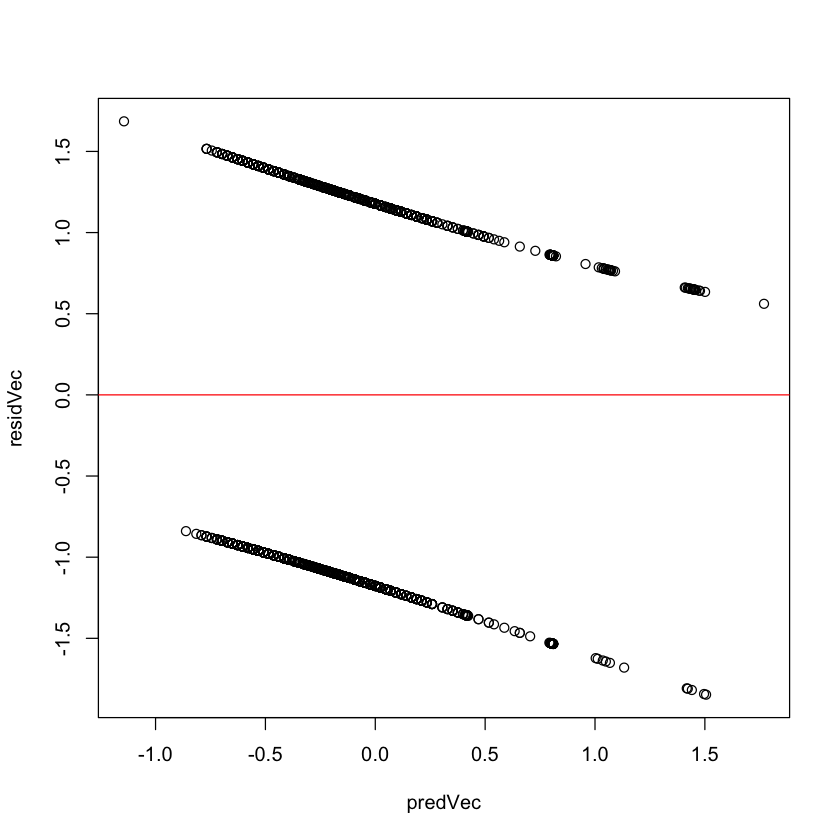

In [68]:
residVec = residuals(oldMod.logr)
predVec = predict(oldMod.logr) #non responses
plot(residVec ~ predVec)
abline(0,0,col = "red")

## Old Model with Time Effects

We will now consider the same model but allowing for slopes to vary based on time.

In [69]:
timeEffectMod.logr = glm(diagnosedWithMHD ~ age*factor(year) + 
                            factor(gender)*factor(year) +
                            factor(isUSA)*factor(year) + age:factor(gender),
                            data = timeDepFrame,family = "binomial")
summary(timeEffectMod.logr)


Call:
glm(formula = diagnosedWithMHD ~ age * factor(year) + factor(gender) * 
    factor(year) + factor(isUSA) * factor(year) + age:factor(gender), 
    family = "binomial", data = timeDepFrame)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9896  -1.1073   0.5978   1.1779   1.7022  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -1.241116   0.276187  -4.494 7.00e-06 ***
age                               0.027657   0.008357   3.309 0.000935 ***
factor(year)2016                 -0.005217   0.369121  -0.014 0.988724    
factor(gender)O                   2.269091   1.125846   2.015 0.043857 *  
factor(gender)W                   1.648158   0.410089   4.019 5.84e-05 ***
factor(isUSA)1                    0.271904   0.121148   2.244 0.024807 *  
age:factor(year)2016             -0.005867   0.010731  -0.547 0.584568    
factor(year)2016:factor(gender)O -0.381104   0.782443  -0.487 0.626209    


In [70]:
#check accuracy
predictions = predict(timeEffectMod.logr,type = "response")
#make decision
decRule = 0.5
timeDepFrame$predictions = ifelse(predictions > decRule,1,0)
#num correct
numCorrect = dim(timeDepFrame[which(timeDepFrame$diagnosedWithMHD
                                == timeDepFrame$predictions),])[1]
propCorrect = numCorrect / dim(timeDepFrame)[1]
print(propCorrect)
#get proportion diagnosed
propDiagnosed = sum(timeDepFrame$diagnosedWithMHD) / dim(timeDepFrame)[1]
print(propDiagnosed)

[1] 0.5944838
[1] 0.5016772


Looks like this model is doing the exact same stuff as the previous model, which may suggest that our time-varying effects could be overfitting.

## Decision Tree with Time Effects

Let us now try to build a decision tree with our effects along with time as a component.

In [71]:
timeMod.tree = tree(diagnosedWithMHD ~ age + factor(gender) + factor(isUSA)
                                       + factor(year),data = timeDepFrame)

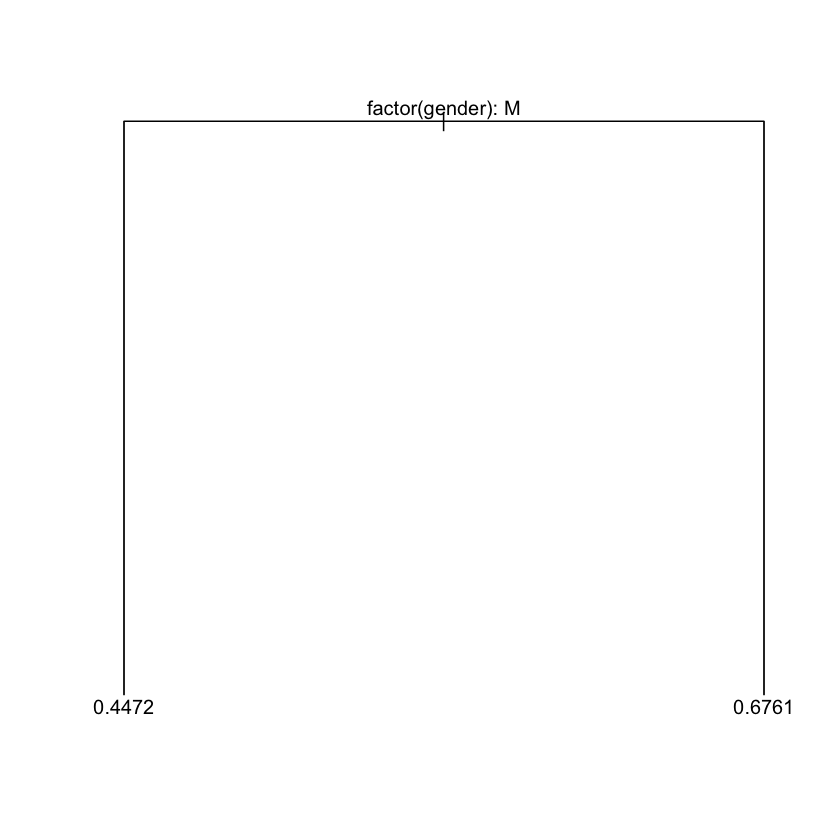

In [72]:
plot(timeMod.tree)
text(timeMod.tree,pretty = TRUE)

_Figure 1: Current Decision Tree._

It seems like the only factor our current decision tree seems to care about is gender, although nonetheless picks up a relevant gender effect. Let's check its accuracy.

In [73]:
#check accuracy
predictions = predict(timeMod.tree)
#make decision
decRule = 0.5
timeDepFrame$predictions = ifelse(predictions > decRule,1,0)
#num correct
numCorrect = dim(timeDepFrame[which(timeDepFrame$diagnosedWithMHD
                                == timeDepFrame$predictions),])[1]
propCorrect = numCorrect / dim(timeDepFrame)[1]
print(propCorrect)
#get proportion diagnosed
propDiagnosed = sum(timeDepFrame$diagnosedWithMHD) / dim(timeDepFrame)[1]
print(propDiagnosed)

[1] 0.5821841
[1] 0.5016772


Interestingly, it is performing about as on par with our other models.

# Model Selection

We will consider our baseline model up to the time varying effects as well as interactions between our current relevant variables and isUK and isCA (since they have not been explored before). I will also include ```companySize``` as a variable in this context as it is apparent that we do not currently have any employer-relevant variables in our baseline models.

We will now perform the data split.

In [74]:
#do test-selection split
numObs = dim(timeDepFrame)[1]
testRows = sample(1:numObs,round(numObs / 2))

In [75]:
testFrame = timeDepFrame[testRows,]
selectionFrame = timeDepFrame[-testRows,]
write.csv(testFrame,"../../data/processed/test_timeDep.csv",row.names = FALSE)

In [76]:
write.csv(selectionFrame,"../../data/processed/train_timeDep.csv",
          row.names = FALSE)

We will perform our selection through a forward-backward stepwise regression procedure. This is mostly because our current search space is rather large, and performing a full cross-validation procedure on the many models to consider might be tenuous on the memory and time available.

In [96]:
lowerMod = paste0("diagnosedWithMHD~1")
upperMod = paste0("diagnosedWithMHD~age+factor(gender)+factor(isUSA)",
                  "+age:factor(gender)+factor(year) + factor(companySize)",
                  "+age:factor(isUK)+factor(gender):factor(isUK)", #isUK
                  "+factor(year):factor(isUK)+factor(isUK)",
                  "+age:factor(isCA)+factor(gender):factor(isCA)", #isCA
                  "+factor(year):factor(isCA)+factor(isCA)",
                  "+age:factor(year)+factor(gender):factor(year)", #year
                  "+factor(isUSA):factor(year)")

In [97]:
baseMod = glm(lowerMod,data = selectionFrame,family = "binomial")
upperMod = glm(upperMod,data = selectionFrame,family = "binomial")

In [98]:
selectedMod.logr = step(baseMod,scope = list(lower=baseMod,upper=upperMod),
                        data = selectionFrame,direction = "both")

Start:  AIC=1860.75
diagnosedWithMHD ~ 1

                      Df Deviance    AIC
+ factor(gender)       2   1805.9 1811.9
+ factor(isUSA)        1   1836.0 1840.0
+ age                  1   1848.9 1852.9
<none>                     1858.8 1860.8
+ factor(isUK)         1   1857.6 1861.6
+ factor(isCA)         1   1858.5 1862.5
+ factor(year)         1   1858.7 1862.7
+ factor(companySize)  5   1854.8 1866.8

Step:  AIC=1811.87
diagnosedWithMHD ~ factor(gender)

                      Df Deviance    AIC
+ factor(isUSA)        1   1789.8 1797.8
+ age                  1   1794.1 1802.1
<none>                     1805.9 1811.9
+ factor(isUK)         1   1805.2 1813.2
+ factor(isCA)         1   1805.3 1813.3
+ factor(year)         1   1805.8 1813.8
+ factor(companySize)  5   1802.0 1818.0
- factor(gender)       2   1858.8 1860.8

Step:  AIC=1797.77
diagnosedWithMHD ~ factor(gender) + factor(isUSA)

                      Df Deviance    AIC
+ age                  1   1780.3 1790.3
<none>      

In [93]:
selectedMod.logr$formula

diagnosedWithMHD ~ factor(gender) + factor(isUSA) + age
<environment: 0x7fc4157dea78>

We see that our selected model has an extremely simple structure, without any reference to time or the other dummies we considered for our structure.

In [95]:
write("diagnosedWithMHD ~ factor(gender) + factor(isUSA) + age",
      file = "../../models/finalTimeDepLogRFormula.txt")